# This notebook is to evaluate embedding derived from networks

# Table of contents
## <a href='#Evaluation-1:-How-do-the-embeddings-look-using-different-size-of-subnetworks?'>1. Evaluate embeddings from different subnetworks</a>
### <a href='#Evaluation-1.1:-How-much-is-the-overlap-between-the-embedding-clusters-from-different-subnetworks'>1.1 How much is the overlap between the embedding clusters that came from different subnetworks?</a>
### <a href='#Evaluation-1.2:-How-much-do-cluster-and-phenotype-correlation-change-when-subnetworks-(vs-whole-network)-were-used-for-embedding?'>1.2 How much do cluster and phenotype correlation change in the embedding that came from whole vs subnetwork?</a>
## <a href='#Evaluation-2:-How-do-the-embeddings-look-using-different-node2vec-parameters?'>2. How do embedding change when different node2vec parameters were used?</a>
### <a href='#Evaluation-2.1:-How-much-do-%-DE-genes-change-in-each-cluster-when-different-parameters-were-used-for-embedding?'>2.1 Evaluate changes in the embeddings by % DE genes in each cluster</a>
### <a href='#Evaluation-2.2:-How-much-do-%-significant-genes-change-in-each-cluster-when-different-parameters-were-used-for-embedding?'>2.2 Evaluate changes in the embeddings by % significant genes in each cluster</a>
### <a href='#Evaluation-2.3:-How-much-do-cluster-and-phenotype-correlation-change-when-different-subnetworks-were-used-for-embedding?'>2.3 Evaluate changes in the embeddings by cluster and phenotype correlation</a>
## <a href='#Evaluation-3:-How-do-the-n_clusters-in-K-means-affect-cluster-and-phenotype-correlation?'>3. How do n_clusters in K means affect cluster and phenotype correlation?</a>
### <a href='#Evaluation-3.1:-How-much-do-%-significant-genes-change-in-each-cluster-when-different-clusters-were-used-for-k-means?'>3.1 Evaluate changes in the clusters by % significant genes in each cluster</a>
### <a href='#Evaluation-3.2:-How-much-do-cluster-and-phenotype-correlation-change-when-different-clusters-were-used-for-k-means?'>3.2 Evaluate changes in the clusters by cluster and phenotype correlation</a>

In [1]:
import sys
sys.path.append("../..")

import pandas as pd
import os
import time
import networkx as nx
from sys import platform 
from src.eda.subset_network import *
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

# Evaluation 1: How do the embeddings look using different size of subnetworks?

In [3]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0) 
comm_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_louvain_default.csv')

Wall time: 5min 50s


<font size=6>New subselection method. When Module Subselection and Embedding Subselect Modules combine, the lines in the below cell shouldn't exist anymore because they will exist from previous steps already

In [7]:
%%time
# New subselection method. When Module Subselection and Embedding Subselect Modules combine, the lines in this cell shouldn't exist anymore because they will exist from previous steps already
G0_n_4, module0_n_4_df, subnetwork_name1 = get_subnetwork([4], 100, 0.015, tom_df, comm_df = comm_df, non_deg_modules = [0], plot_hist = None, 
                                                          hist_dir = None, subnetwork_dir = None)
G1_n_4, module1_n_4_df, subnetwork_name2 = get_subnetwork([4], 125, 0.01, tom_df, comm_df = comm_df, non_deg_modules = [1], plot_hist = None, 
                                                          hist_dir = None, subnetwork_dir = None)
G2_n_4, module2_n_4_df, subnetwork_name3 = get_subnetwork([4], 150, 0.01, tom_df, comm_df = comm_df, non_deg_modules = [2], plot_hist = None, 
                                                          hist_dir = None, subnetwork_dir = None)
G3_n_4, module3_n_4_df, subnetwork_name4 = get_subnetwork([4], 150, 0.02, tom_df, comm_df = comm_df, non_deg_modules = [3], plot_hist = None, 
                                                          hist_dir = None, subnetwork_dir = None)
G4, module4_df, subnetwork_name5 = get_subnetwork([4], 250, 0.008, tom_df, comm_df = comm_df, non_deg_modules = [], plot_hist = None, 
                                                  hist_dir = None, subnetwork_dir = None)

Number of edges: 94166
Number of edges: 82325
Number of edges: 74113
Number of edges: 89152
Number of edges: 82208
Wall time: 1min 26s


In [8]:
subnetwork_Gs = [G0_n_4, G1_n_4, G2_n_4, G3_n_4, G4]
subnetwork_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3, subnetwork_name4, subnetwork_name5]

<font size=6> This is a time-consuming step. Took several hours!

In [ ]:
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Jan12/'
%%time
emb_list = []
kmeans_list = []
for i, G in enumerate(subnetwork_Gs):
    emb_df = network_embedding(G, 16, 100, 10, embedding_path, subnetwork_names[i])
    emb_list.append(emb_df)
    kmeans_list.append(run_kmeans(emb_df, 5))

## Evaluation 1.1: How much is the overlap between the embedding clusters from different subnetworks

### Evalutaion 1.1a: Jaccard to compare cluster similarity

In [9]:
## The codes here are only when I re-open a session and don't want to redo embeddding, I could just import the embedding df but for containerization, this step is not needed.

# embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Jan12/'
# emb_list = []
# kmeans_list = []
# i = 0
# for file in os.listdir(embedding_path):
#     emb = pd.read_csv(embedding_path + file, index_col = 0)
#     emb_list.append(emb)
#     kmeans_list.append(run_kmeans(emb, 5))
#     i += 1

<font size=6>I chose to compare between the first embedding with the 2nd, 3rd and so on but this should be the user's choice. There's no rule on which one should be compared to which one.

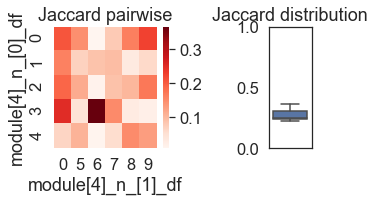

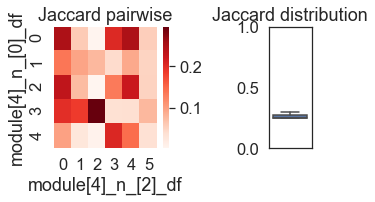

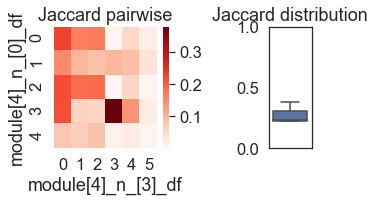

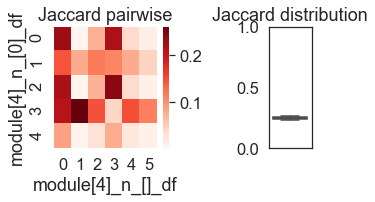

In [11]:
for i in range(1, 5):
    cluster_jaccard(kmeans_list[0], kmeans_list[i], 'kmean_label', [subnetwork_names[0], subnetwork_names[i]], top = 3)

### Evalutaion 1.1b: NMI to compare cluster similarity

<font size=6>This is another place that the user can decide which embedding they want to compare. I used the following for loop to find the embedding with the most nodes and compare everything else against that one. 

In [13]:
for i in range(5):
    print(len(kmeans_list[i]))

6380
7510
5973
4333
3908


Wall time: 545 ms


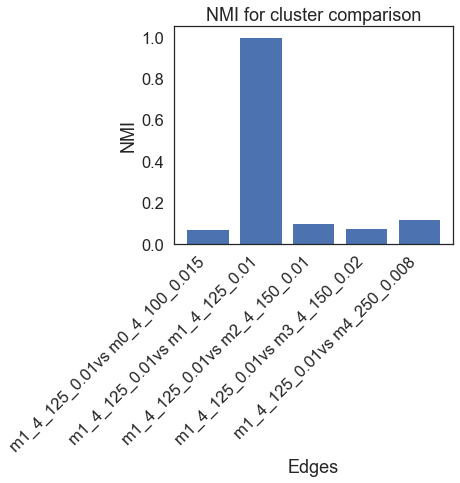

In [40]:
%%time
networK_comparison_names = [subnetwork_names[1] + f'vs {subnetwork_names[i]}' for i in range(5)]
plot_cluster_nmi_comparison(subnetwork_names[1], kmeans_list[1], kmeans_list, 
                            'kmean_label', networK_comparison_names)

## Evaluation 1.2: How much do cluster and phenotype correlation change when subnetworks (vs whole network) were used for embedding?

### Evaluation 1.2a: compare whole network and subnetwork embedding by % DE in each cluster

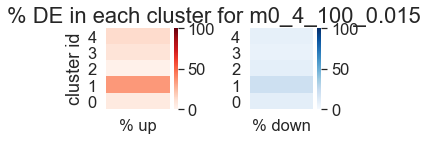

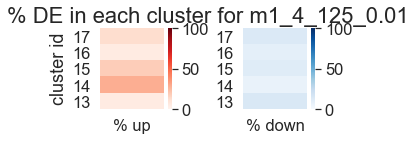

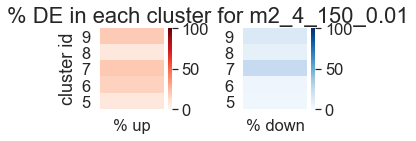

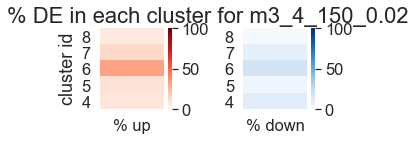

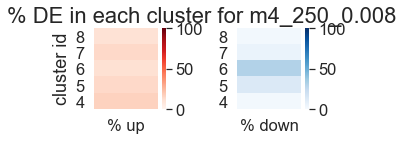

In [41]:
# Note that this is just an example of comparing different subnetwork embedding, not necessarily a great subnetwork example
for i, kmeans in enumerate(kmeans_list):
    cluster_DE_perc(kmeans, 'kmean_label', subnetwork_names[i])

### Evaluation 1.2b: Measure percentage of genes in each cluster that are significantly variable for specific traits

In [2]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)

Wall time: 4min 44s


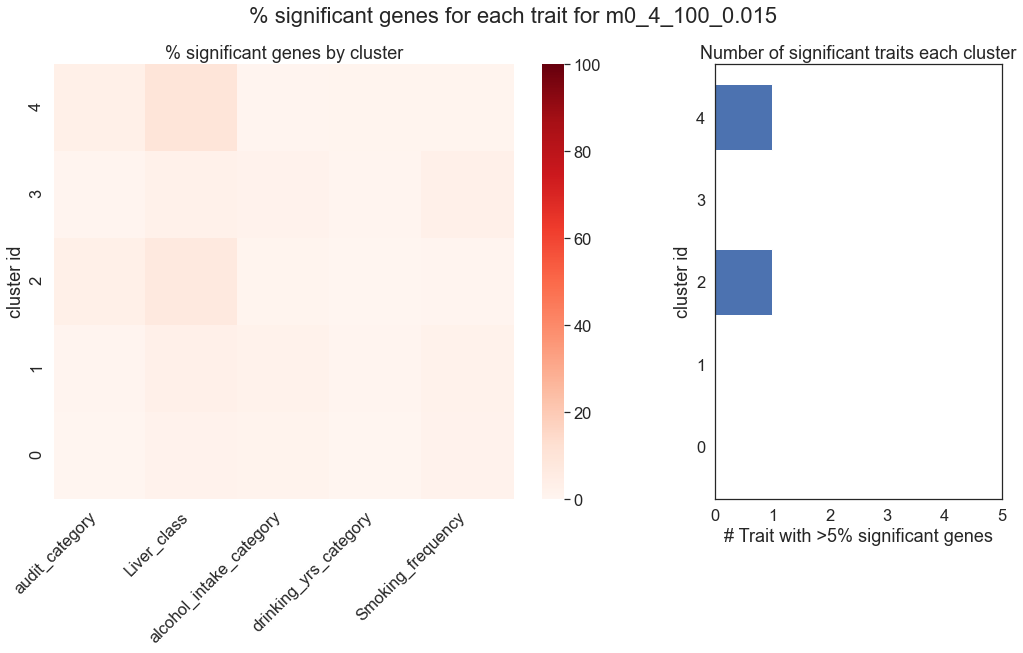

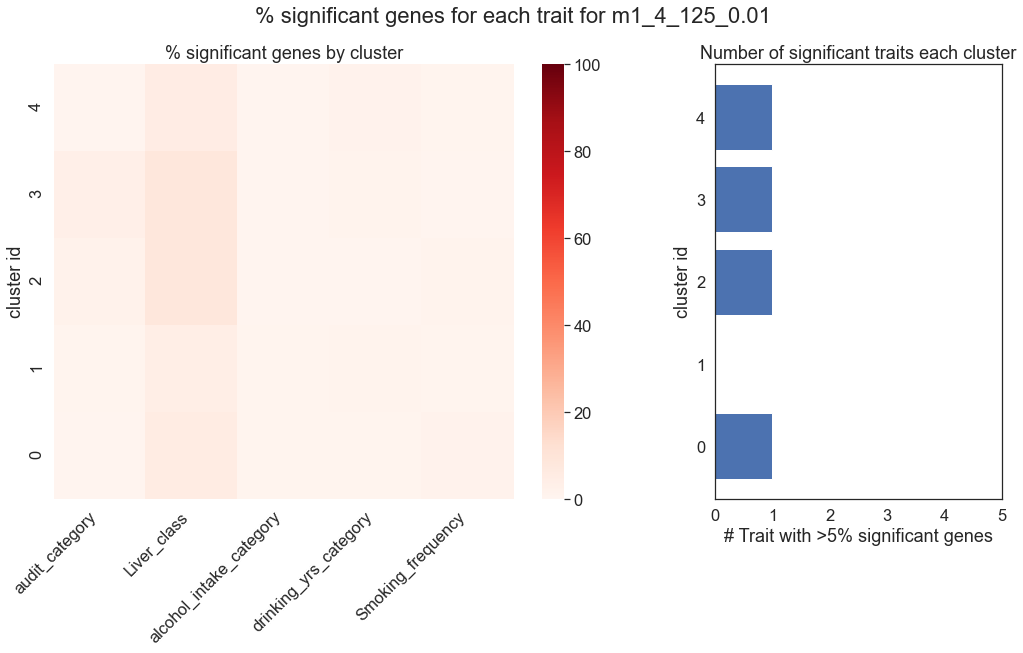

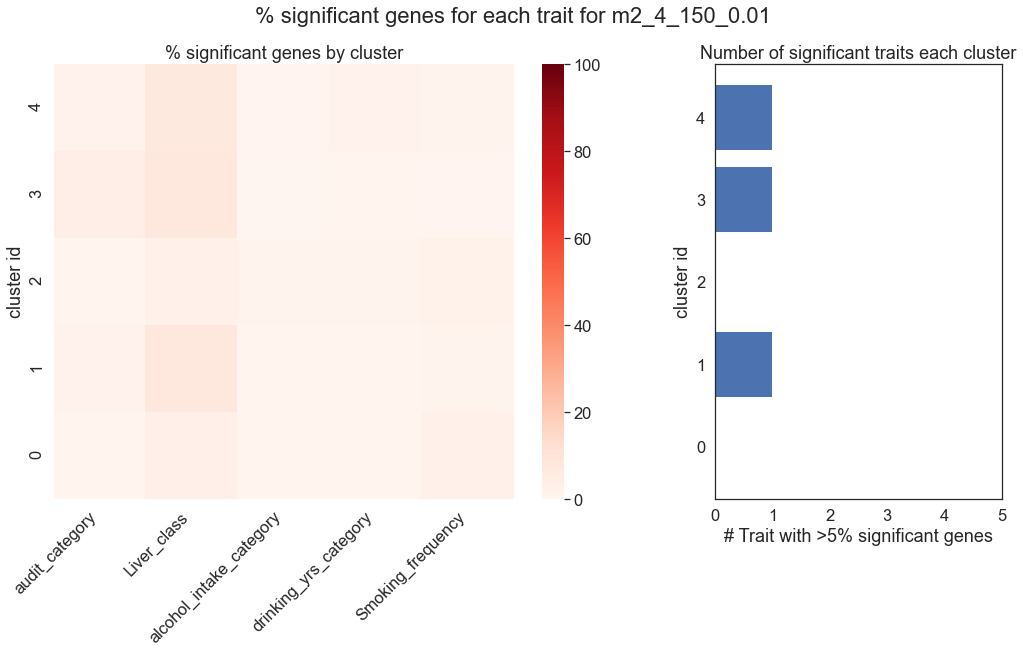

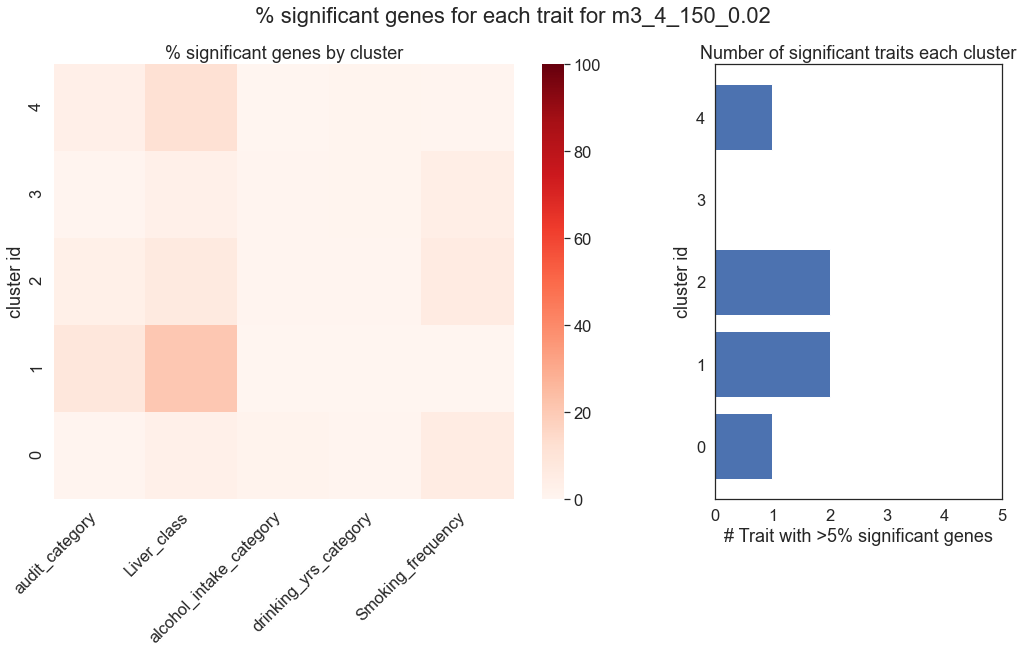

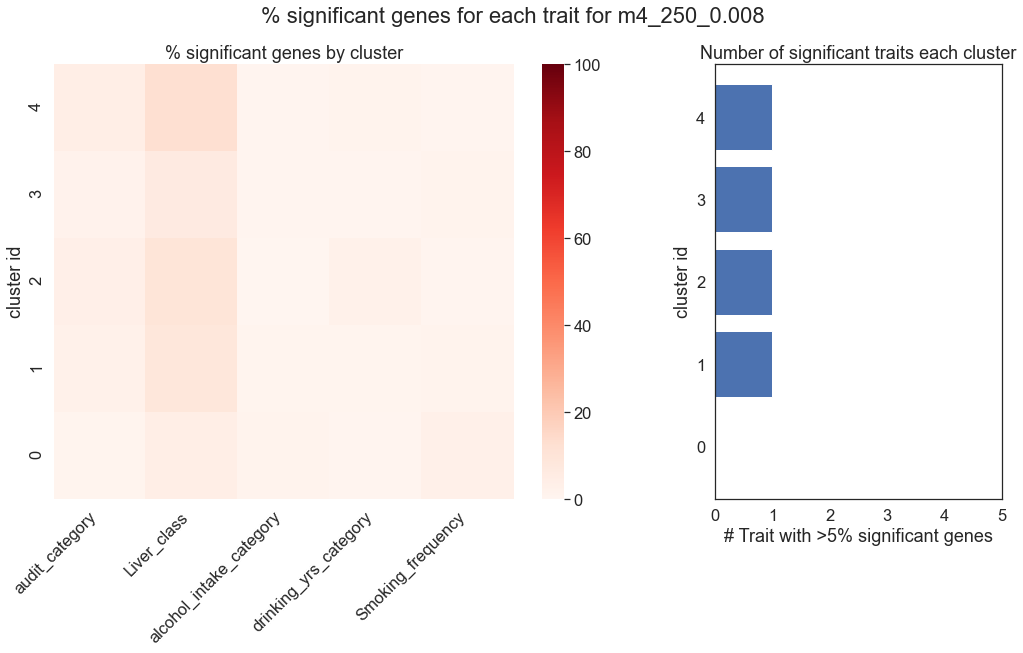

In [15]:
%%time
for i, kmeans in enumerate(kmeans_list):
    plot_sig_perc(kmeans, 'kmean_label', subnetwork_names[i], expression_meta_df)

### Evaluation 1.2c: Measure cluster and alcohol phenotype correlation

Wall time: 15.2 s


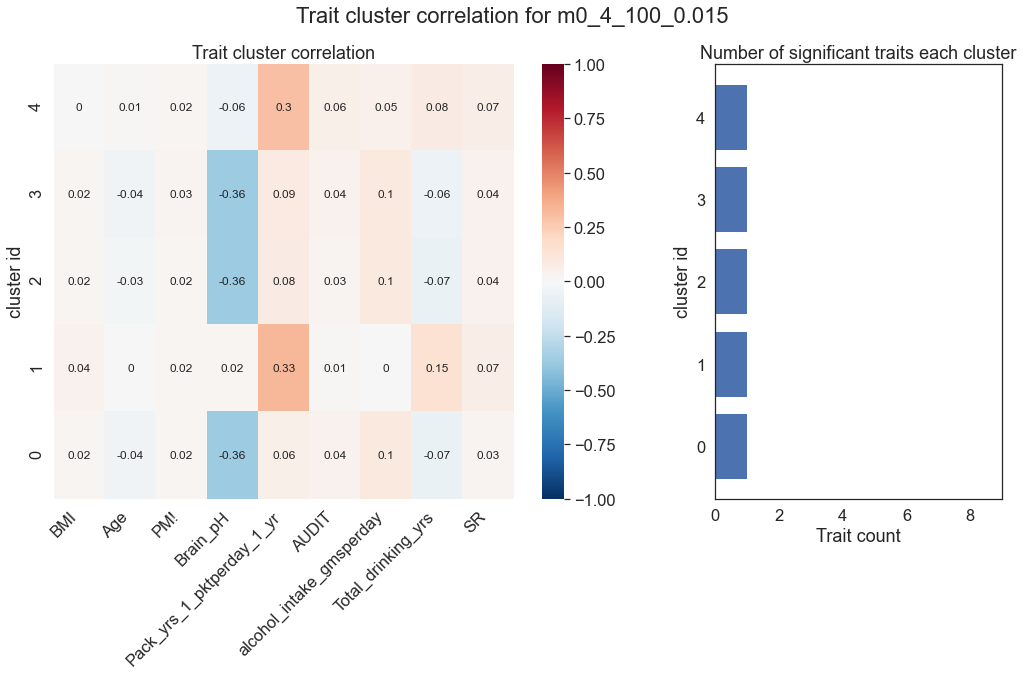

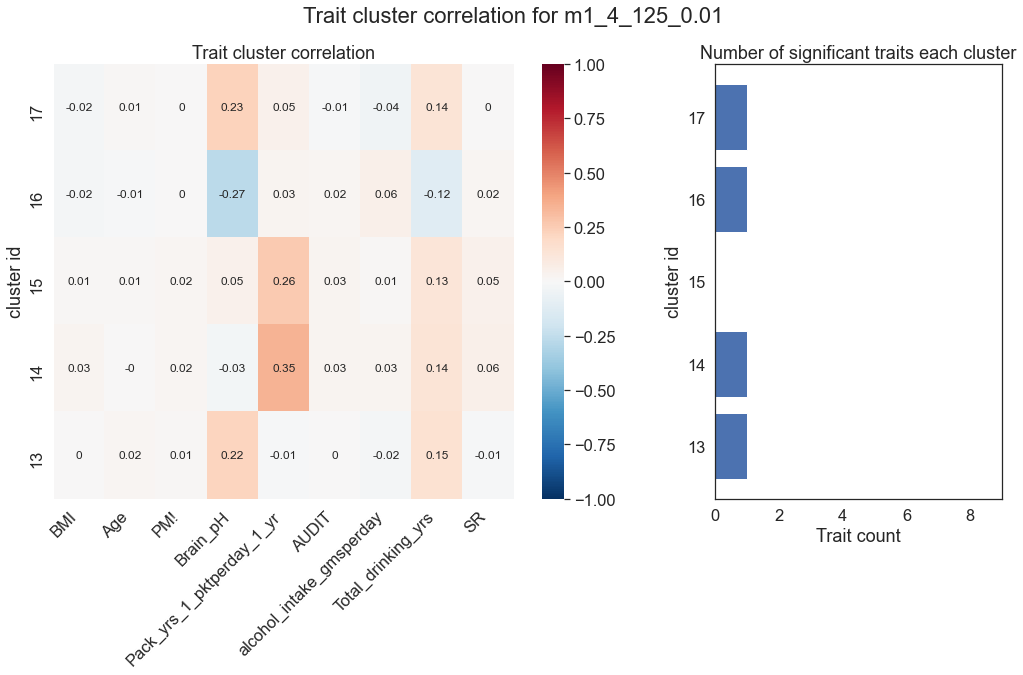

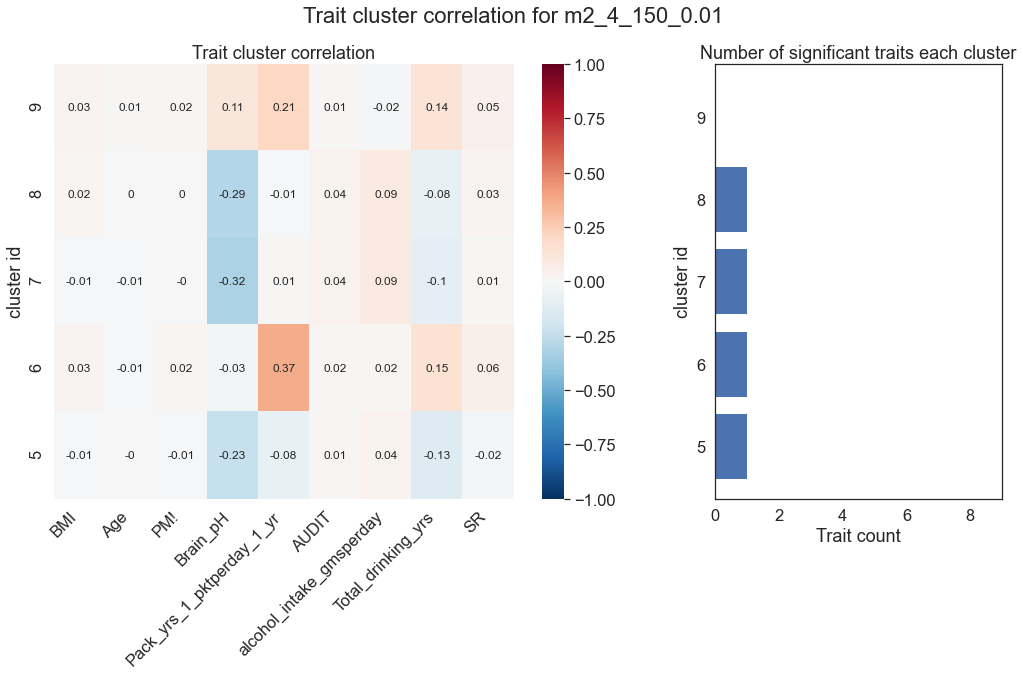

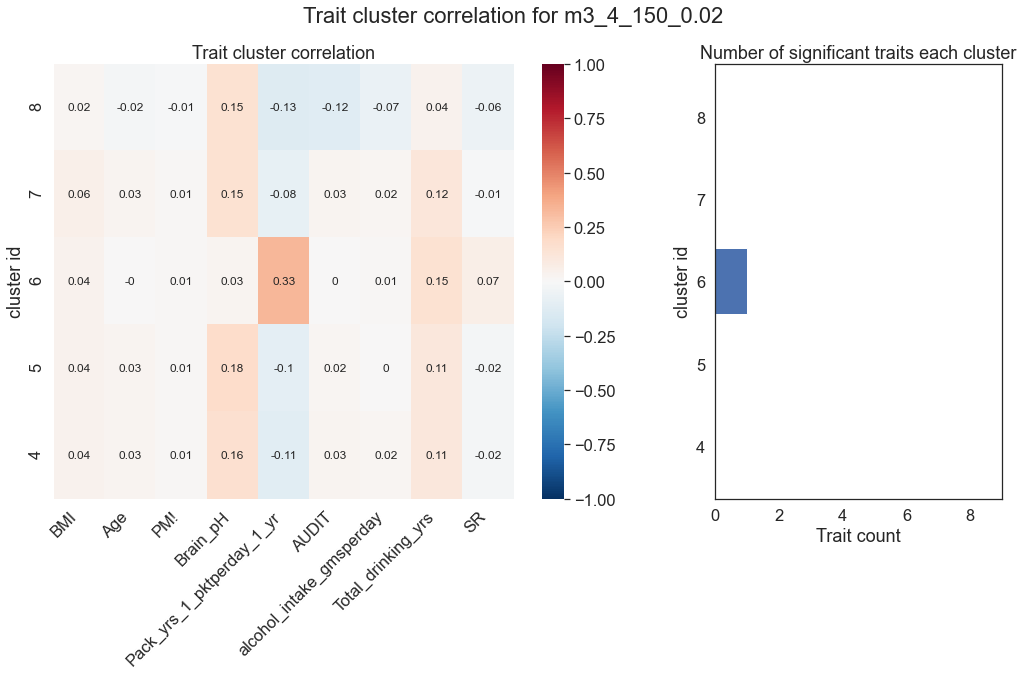

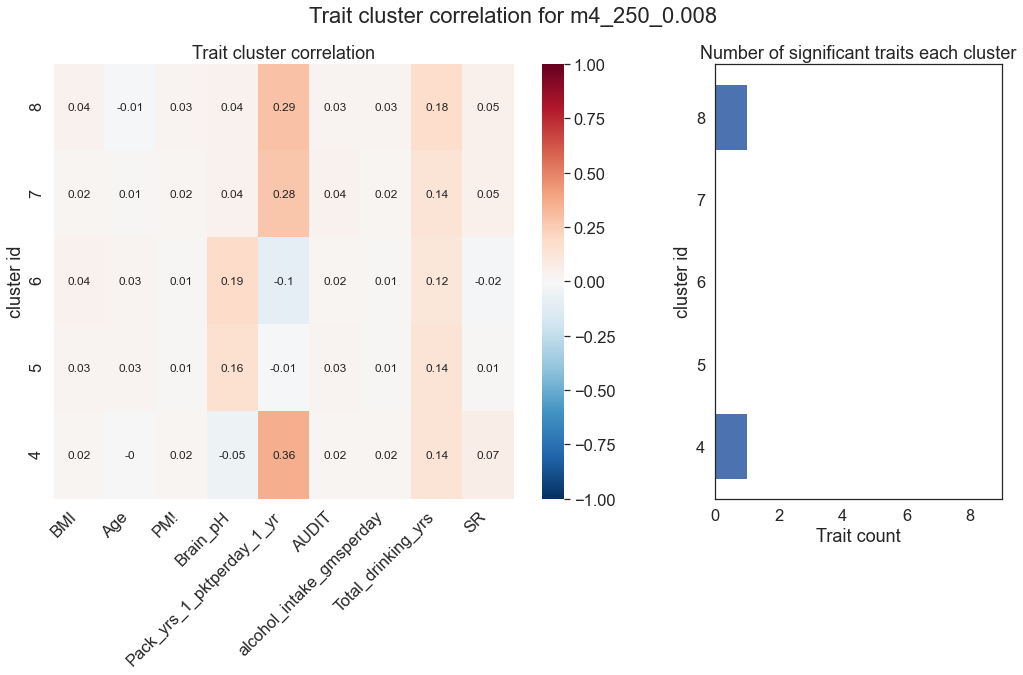

In [45]:
%%time
for i, kmeans in enumerate(kmeans_list):
    cluster_phenotype_corr(kmeans, 'kmean_label', subnetwork_names[i], expression_meta_df)

# Evaluation 2: How do the embeddings look using different node2vec parameters?

<font size=6> Note that it takes 2-4 hours to embed each network. The total runtime is approximately a whole day!!

In [ ]:
%%time
# 2x2 sets of parameters for embedding
embedding_path2 = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Jan13/'
kmeans_list2 = []
parameters = []
for length in [16, 64]:
    for num_walk in [100, 300]: # only use the first embedding to test different parameters based on the EDA
        emb_df = network_embedding(G0_n_4, length, num_walk, 10, embedding_path2, subnetwork_names[0]) # use the network with 5k edges as a test (less computationally intensive)
        kmeans_list2.append(run_kmeans(emb_df, 5)) # run k means 
        parameters.append(f'length={length},num_walk={num_walk}') # add the parameter name to the parameters list

## Evaluation 2.1: How much do % DE genes change in each cluster when different parameters were used for embedding?

In [24]:
## Could load the embedding from the directory if you start with a new session
# kmeans_list2 = []
# for file in os.listdir(embedding_path2):
#     emb_df = pd.read_csv(embedding_path2 + file, index_col = 0)
#     kmeans_list2.append(run_kmeans(emb_df, 5)) # run k means 

Wall time: 838 ms


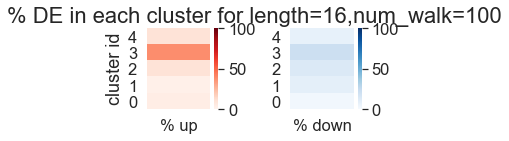

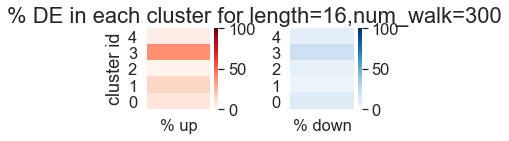

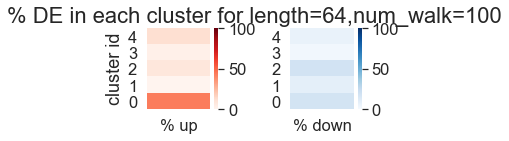

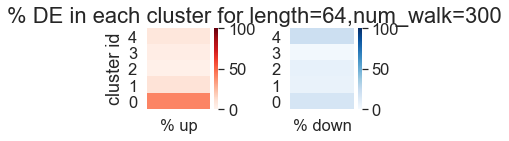

In [36]:
%%time
for i in range(4):
    cluster_DE_perc(kmeans_list2[i], 'kmean_label', parameters[i])

## Evaluation 2.2: How much do % significant genes change in each cluster when different parameters were used for embedding?

In [ ]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)

Wall time: 5min 15s


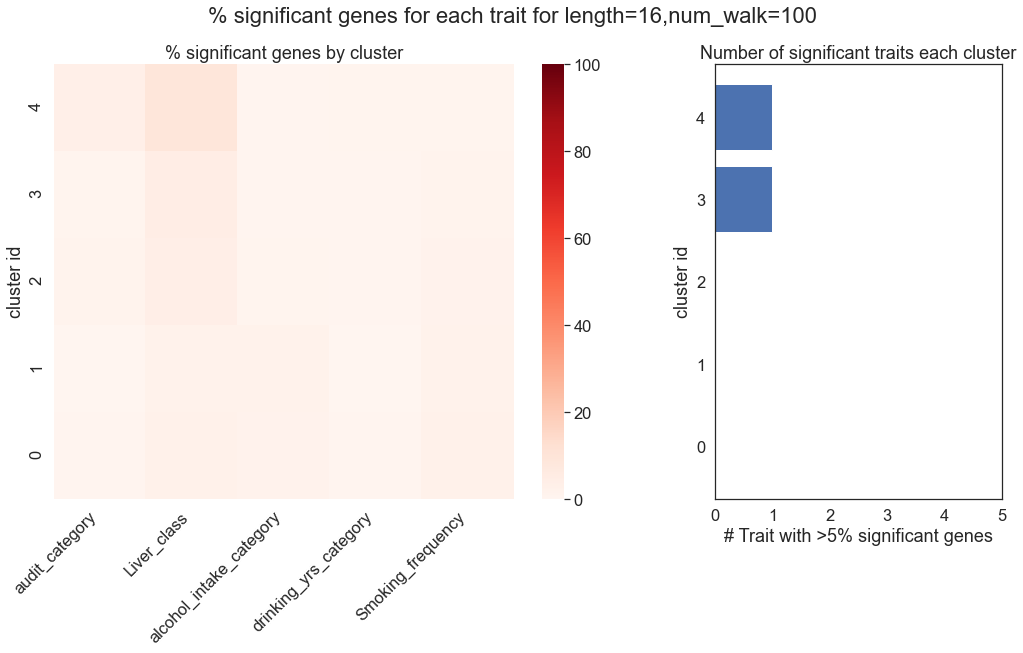

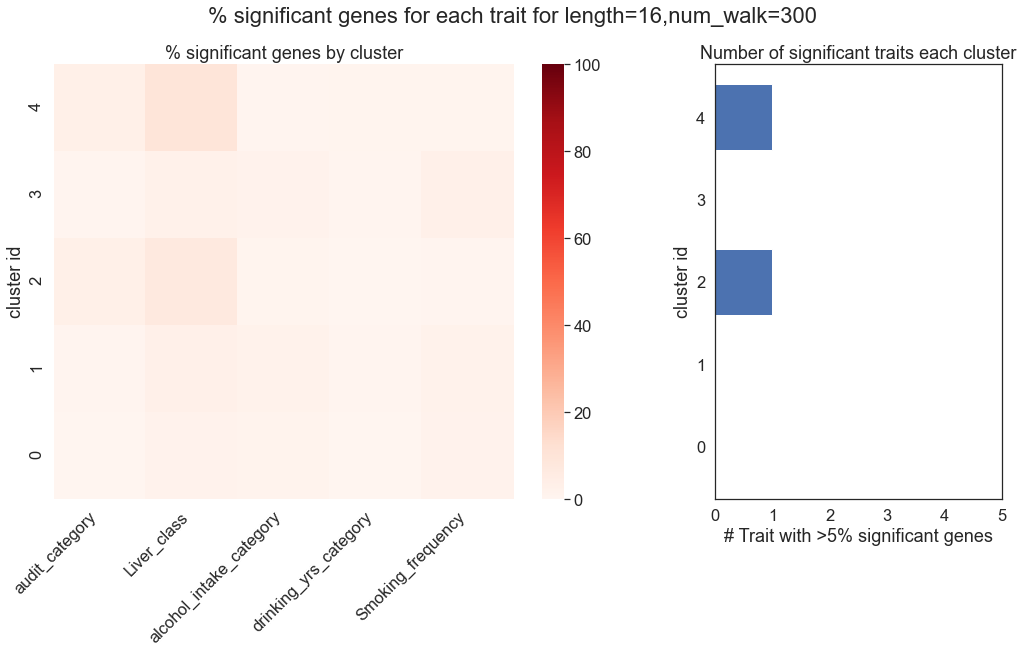

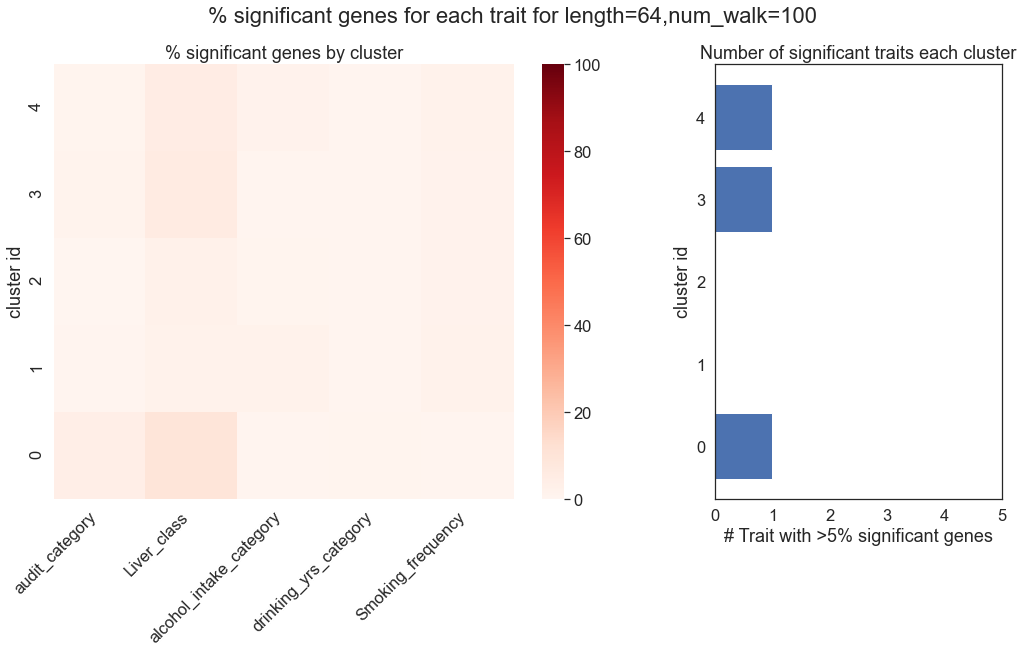

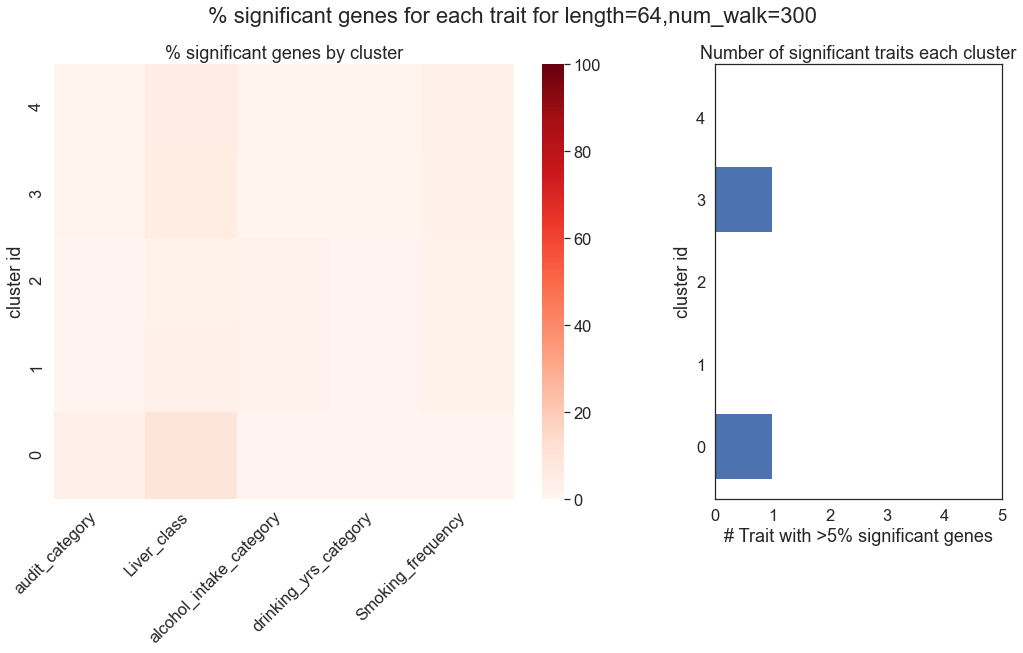

In [41]:
%%time
for i in range(4):
    plot_sig_perc(kmeans_list2[i], 'kmean_label', parameters[i], expression_meta_df)

## Evaluation 2.3: How much do cluster and phenotype correlation change when different subnetworks were used for embedding?

Wall time: 5.84 s


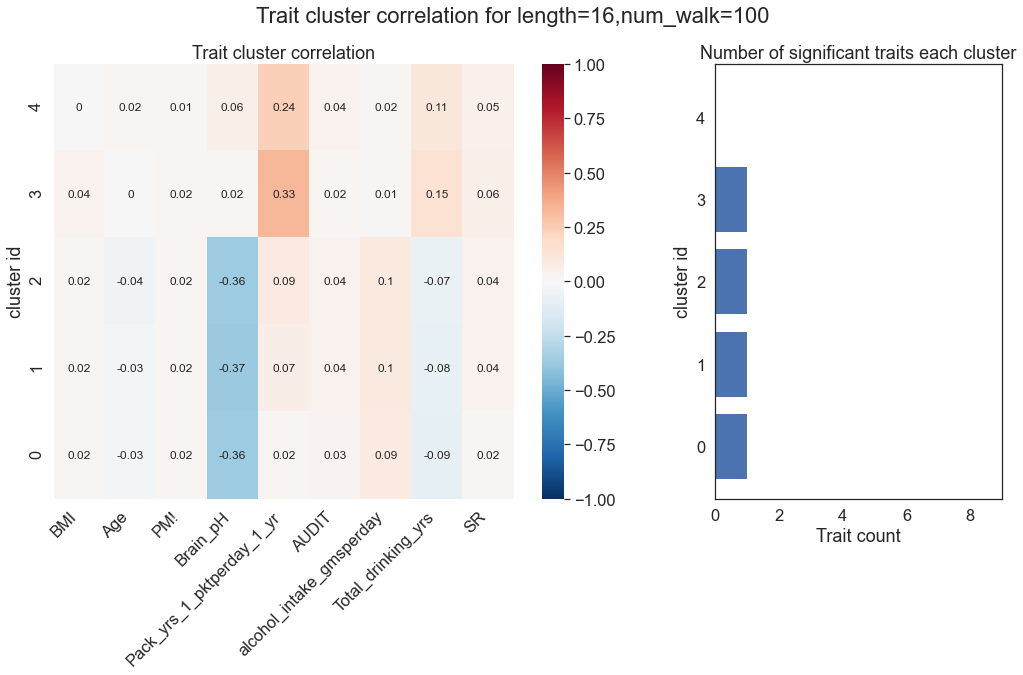

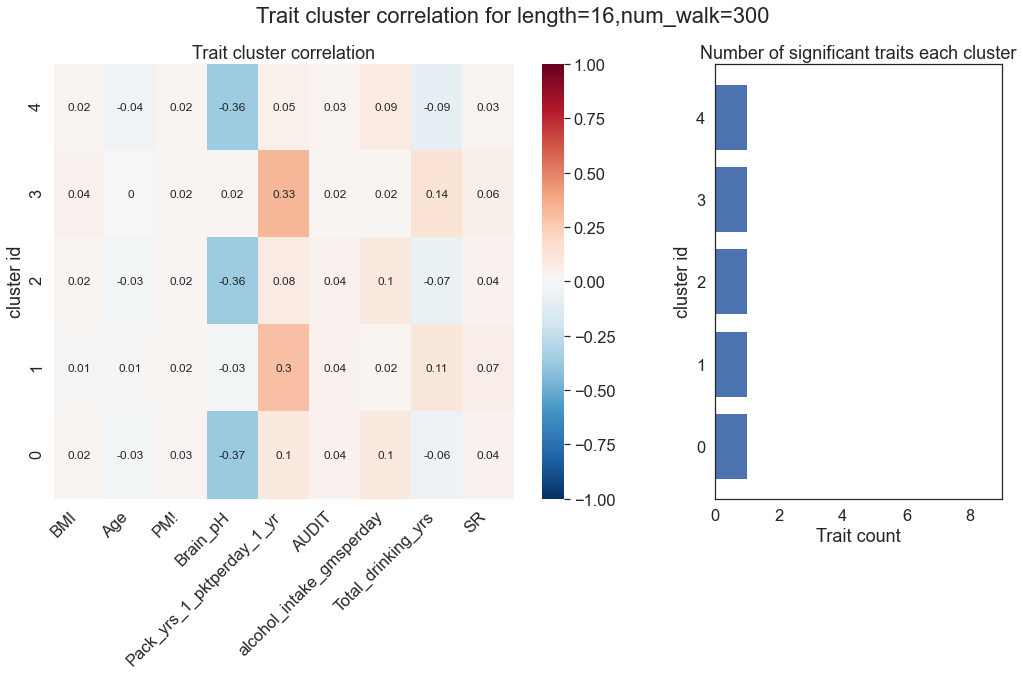

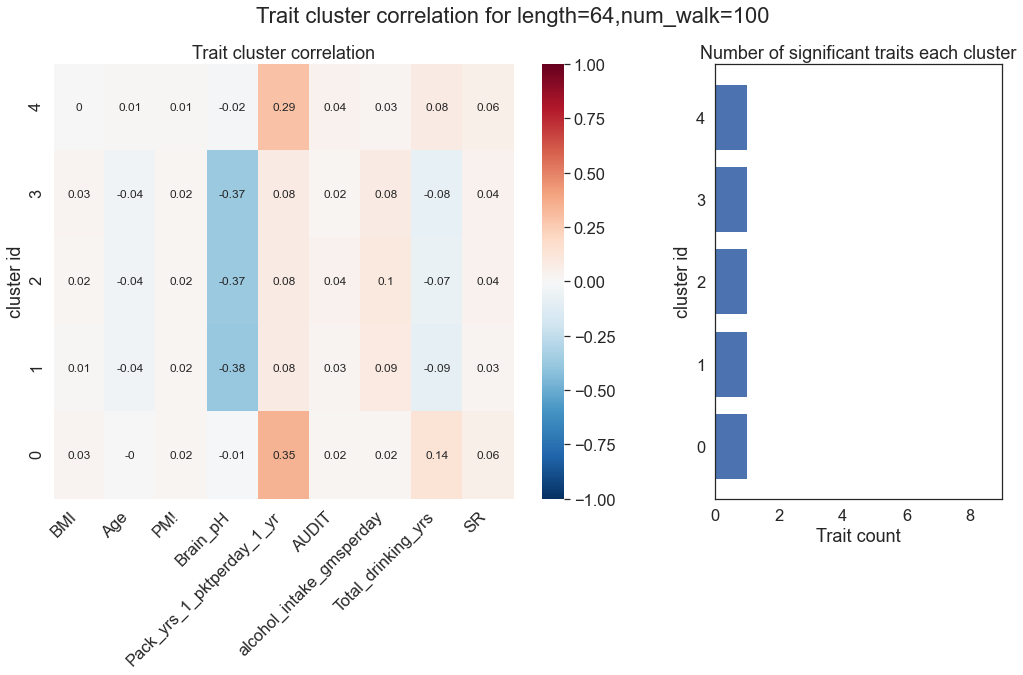

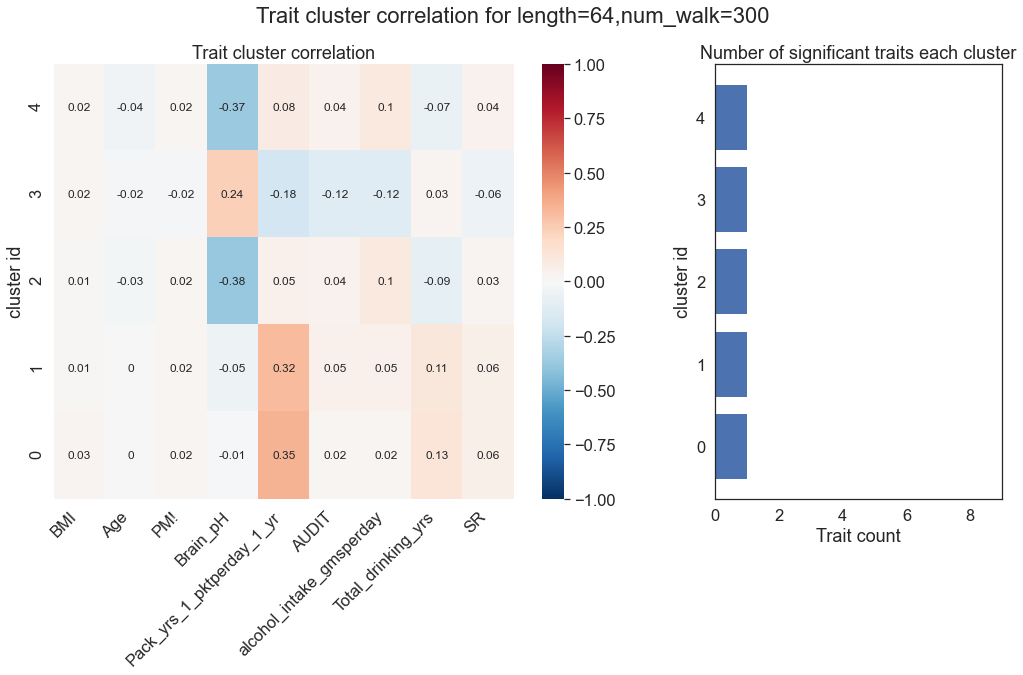

In [37]:
%%time
for i in range(4):
    cluster_phenotype_corr(kmeans_list2[i], 'kmean_label', parameters[i], expression_meta_df)

# Evaluation 3: How do the n_clusters in K means affect cluster and phenotype correlation?

In [38]:
# using the embeddings from 5k edges as an example, but the same method could be applied to any embedding 
kmeans_test = []
emb = pd.read_csv(embedding_path + 'embedded_len16_walk100_m0_4_100_0.015.csv', index_col = 0)
n_list = [5,10,20]
for n in n_list:
    kmeans_test.append(run_kmeans(emb, n))

## Evaluation 3.1: How much do % significant genes change in each cluster when different clusters were used for k means?

Wall time: 2min 56s


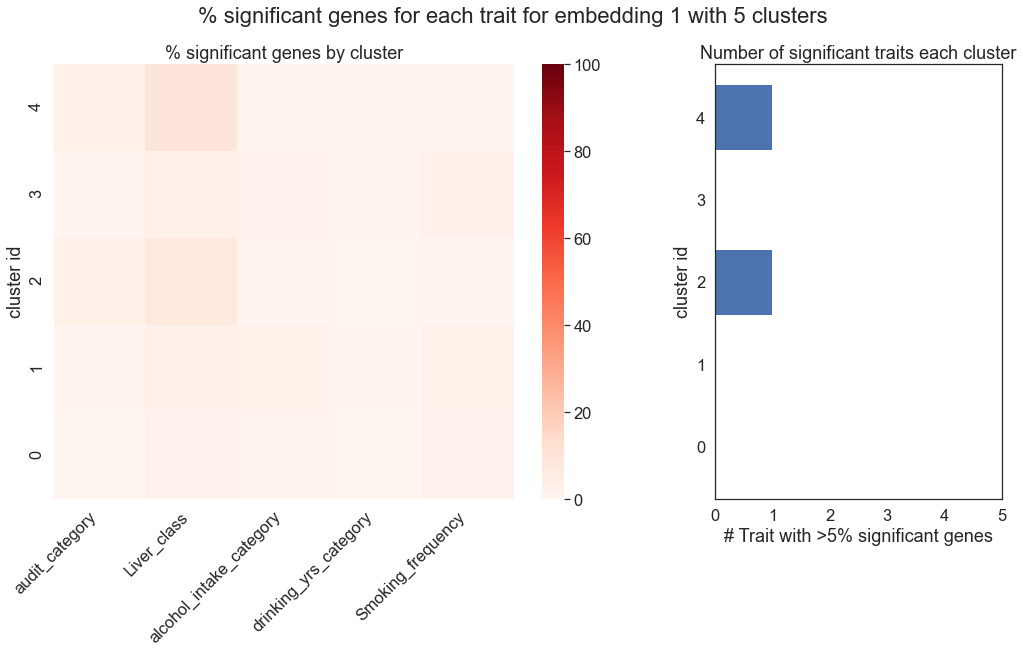

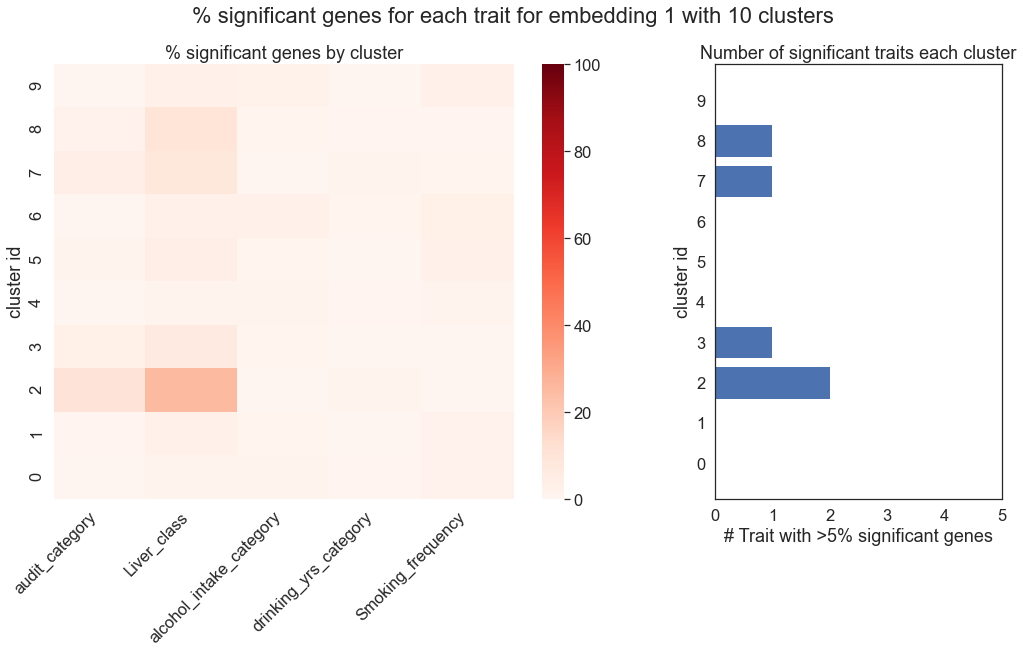

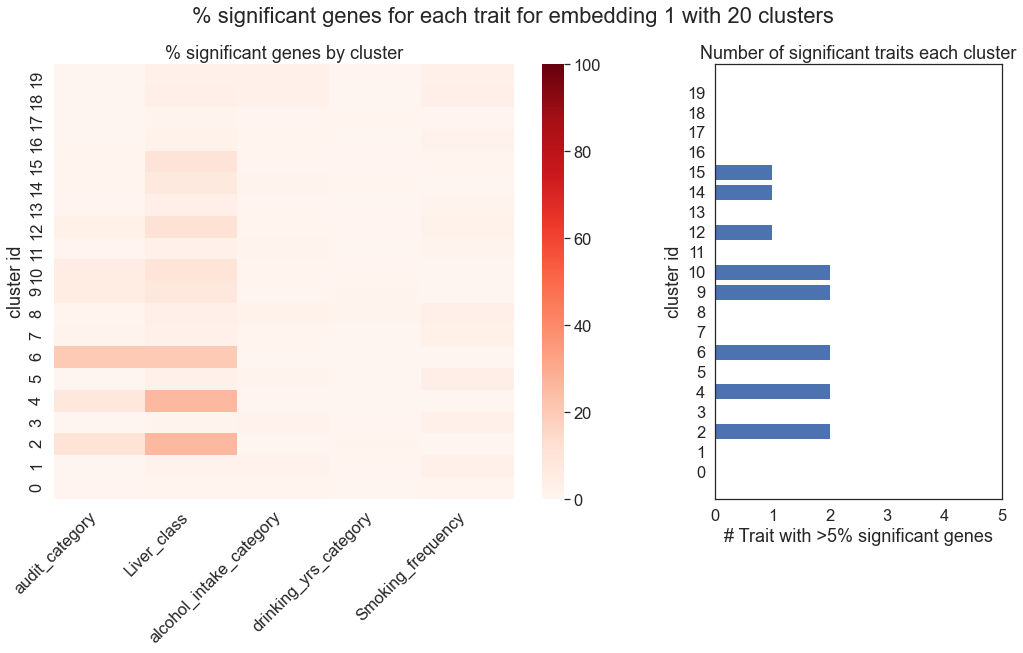

In [39]:
%%time
for i in range(3):
    plot_sig_perc(kmeans_test[i], 'kmean_label', f'embedding 1 with {n_list[i]} clusters', expression_meta_df)

## Evaluation 3.2: How much do cluster and phenotype correlation change when different clusters were used for k means?

Wall time: 5.8 s


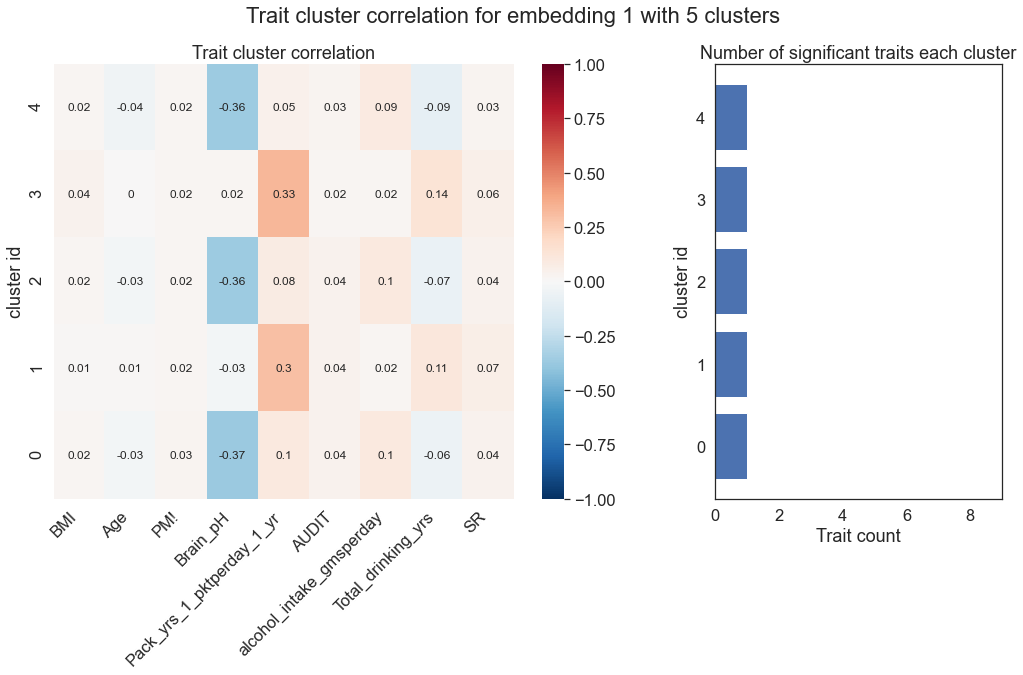

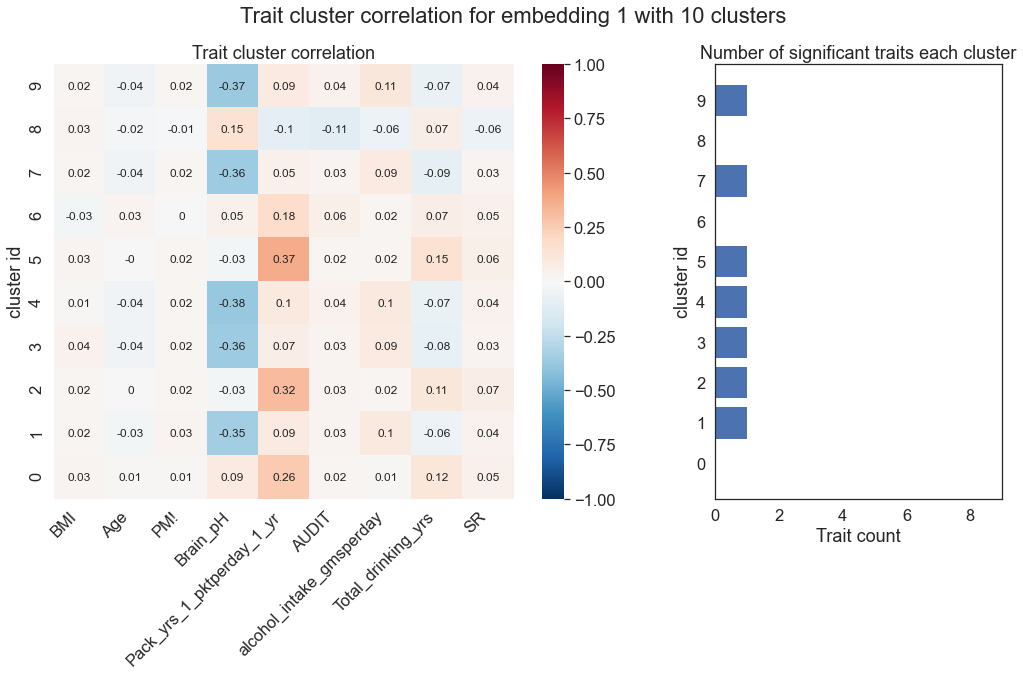

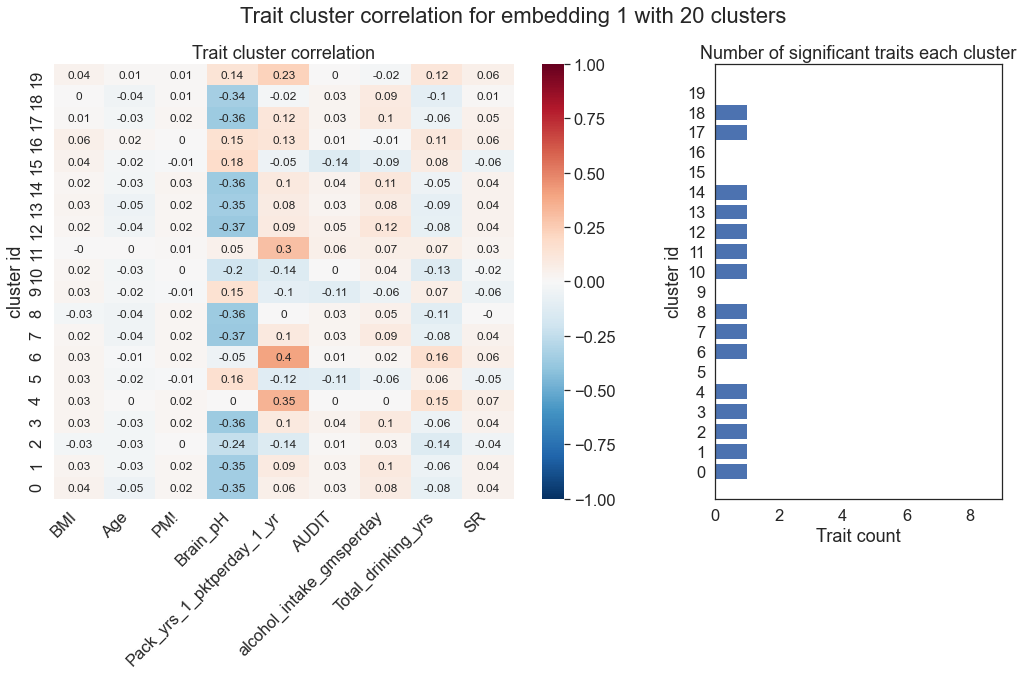

In [40]:
%%time
for i in range(3):
    cluster_phenotype_corr(kmeans_test[i], 'kmean_label', f'embedding 1 with {n_list[i]} clusters', expression_meta_df)